In [33]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import gc
from scipy import stats
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 8]  # Bigger images

In [3]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['Row', 'Timestamp', 'EDA', 'ECG', 'EventLabel', 'Participant'])


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv'): 
        data = pd.read_csv(file_path, comment='#',low_memory=False)
        if 'Channel 9 (EDA100C)' in data.columns:
            eda_column = 'Channel 9 (EDA100C)'
            ecg_column = 'Channel 13 (ECG100C)'
        elif 'Channel 9 (Raw)' in data.columns:
            eda_column = 'Channel 9 (Raw)'
            ecg_column = 'Channel 13 (Raw)'
        data = data[['Row', 'Timestamp', eda_column, ecg_column,'MarkerName','MarkerType']]
        start, end = data.query('MarkerName == "Experiment" and MarkerType == "S"').index.values[0], data.query('MarkerName == "Experiment" and MarkerType == "E"').index.values[0]
        data = data[start:end+1]
        data.reset_index(inplace=True, drop=True)
        markers =  list(data[data['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data[(data.MarkerName == m) & (data.MarkerType == "S")].index.values[0]
            end = data[(data.MarkerName == m) & (data.MarkerType == "E")].index.values[0]
            data.loc[start:end, 'EventLabel'] = data.loc[start:end, 'EventLabel'].fillna(m)
        data['EventLabel'] = data['EventLabel'].fillna('Silence')
        data.dropna(subset=[eda_column, ecg_column], inplace=True)
        data.drop(columns=['MarkerName', 'MarkerType'], inplace=True)
        data['Participant'] = [filename.split('.')[0]] * len(data)
        data.rename(columns={eda_column: 'EDA', ecg_column:'ECG'}, inplace=True)
        data_full = pd.concat([data_full, data], ignore_index=True)
        del data
        gc.collect()
 
  
data_full

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_90136/2183265743.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, data], ignore_index=True)


,Row,Timestamp,EDA,ECG,EventLabel,Participant
0,4507,10545.0005,1.191406,0.973206,Silence,I8L4N6G7
1,4508,10550.0005,1.192017,1.372375,Silence,I8L4N6G7
2,4509,10555.0005,1.191711,1.466064,Silence,I8L4N6G7
3,4514,10560.0005,1.192322,1.022949,Silence,I8L4N6G7
4,4515,10565.0005,1.192322,0.177612,Silence,I8L4N6G7
...,...,...,...,...,...,...
3050935,397469,933564.2909,1.839600,-0.037537,Silence,K4G7Y9O2
3050936,397471,933569.2909,1.841431,-0.045776,Silence,K4G7Y9O2
3050937,397472,933574.2909,1.839905,-0.041504,Silence,K4G7Y9O2
3050938,397473,933579.2909,1.840210,-0.043945,Silence,K4G7Y9O2


In [5]:
sampling_rate = 200

In [7]:
mask_silence = (data_full["EventLabel"] == "Silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [8]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines = data_full[mask_silence]

In [29]:
def extract_eda_info(df):
    n_peaks = []
    ampl_peaks = []

    for participant, data in df.groupby(by='Participant'):
        signal, _= nk.eda_process(data.EDA, sampling_rate=sampling_rate)
        d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
        n_peaks.append(d['SCR_Peaks_N'][0])
        ampl_peaks.append(d['SCR_Peaks_Amplitude_Mean'][0])

    return n_peaks,  ampl_peaks

n_peaks_pos, ampl_peaks_pos = extract_eda_info(positives)
n_peaks_neg, ampl_peaks_neg = extract_eda_info(negatives)
n_peaks_bas, ampl_peaks_bas = extract_eda_info(baselines)

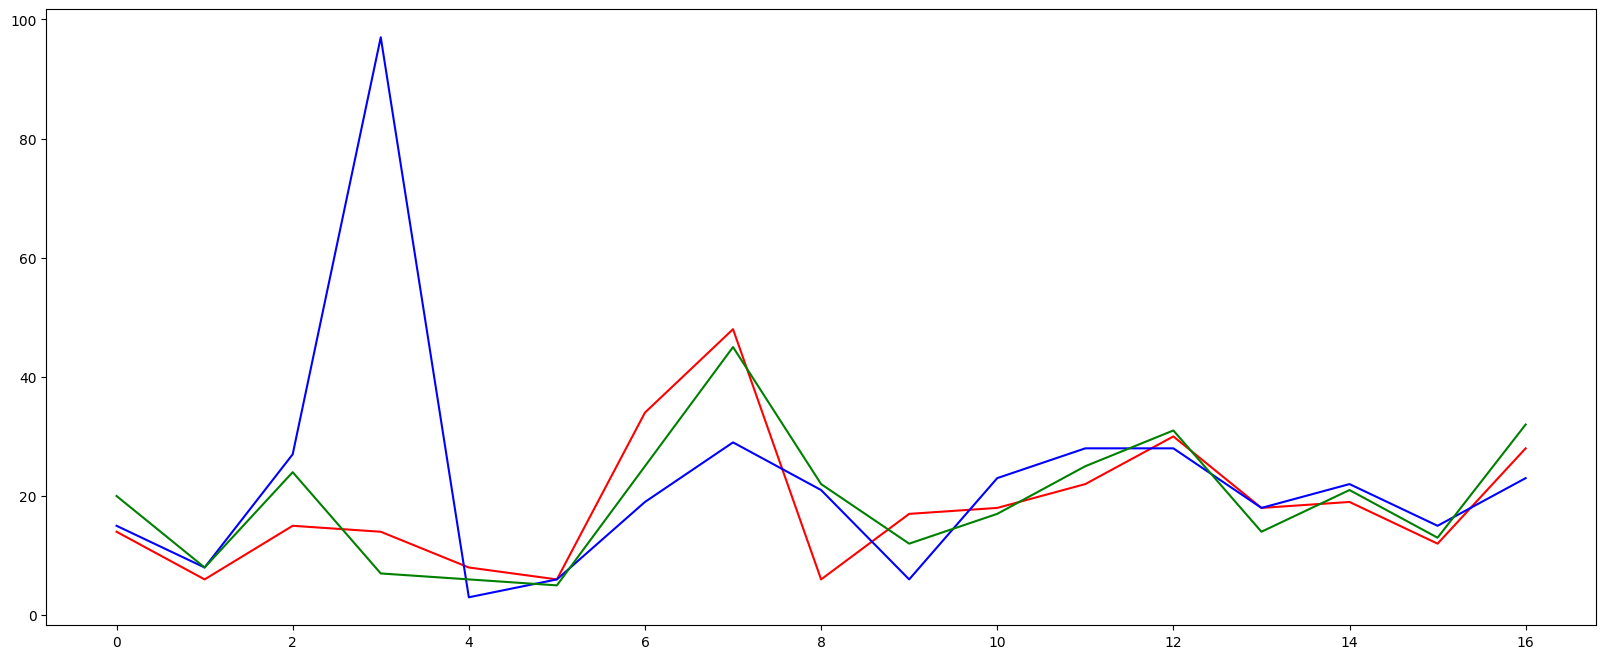

In [30]:
plt.plot(n_peaks_pos, 'r') # plotting t, a separately 
plt.plot(n_peaks_neg, 'b') # plotting t, b separately 
plt.plot(n_peaks_bas, 'g') # plotting t, c separately 
plt.show()

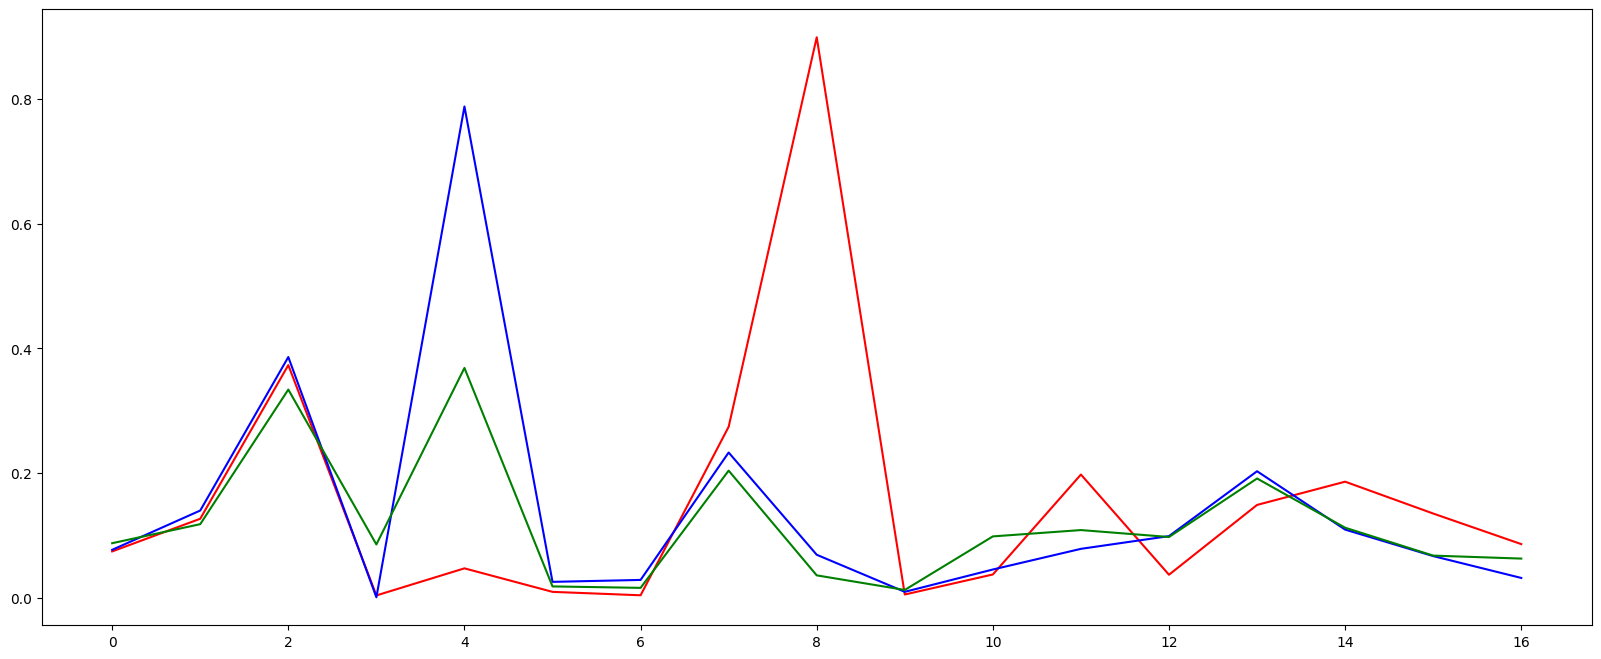

In [31]:
plt.plot(ampl_peaks_pos, 'r') # plotting t, a separately 
plt.plot(ampl_peaks_neg, 'b') # plotting t, b separately 
plt.plot(ampl_peaks_bas, 'g') # plotting t, c separately 
plt.show()

In [39]:
np.random.seed(42)  # For reproducibility
n_participants = len(n_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline': n_peaks_bas,  
    'Positive': n_peaks_pos,
    'Negative': n_peaks_neg
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline: statistic=0.947, p=0.411
Shapiro-Wilk test for Positive: statistic=0.896, p=0.059
Shapiro-Wilk test for Negative: statistic=0.645, p=0.000
  Negative is not normally distributed (p < 0.05)


Doing Friedman

Friedman Test Results:
Chi-square=0.400, p=0.819


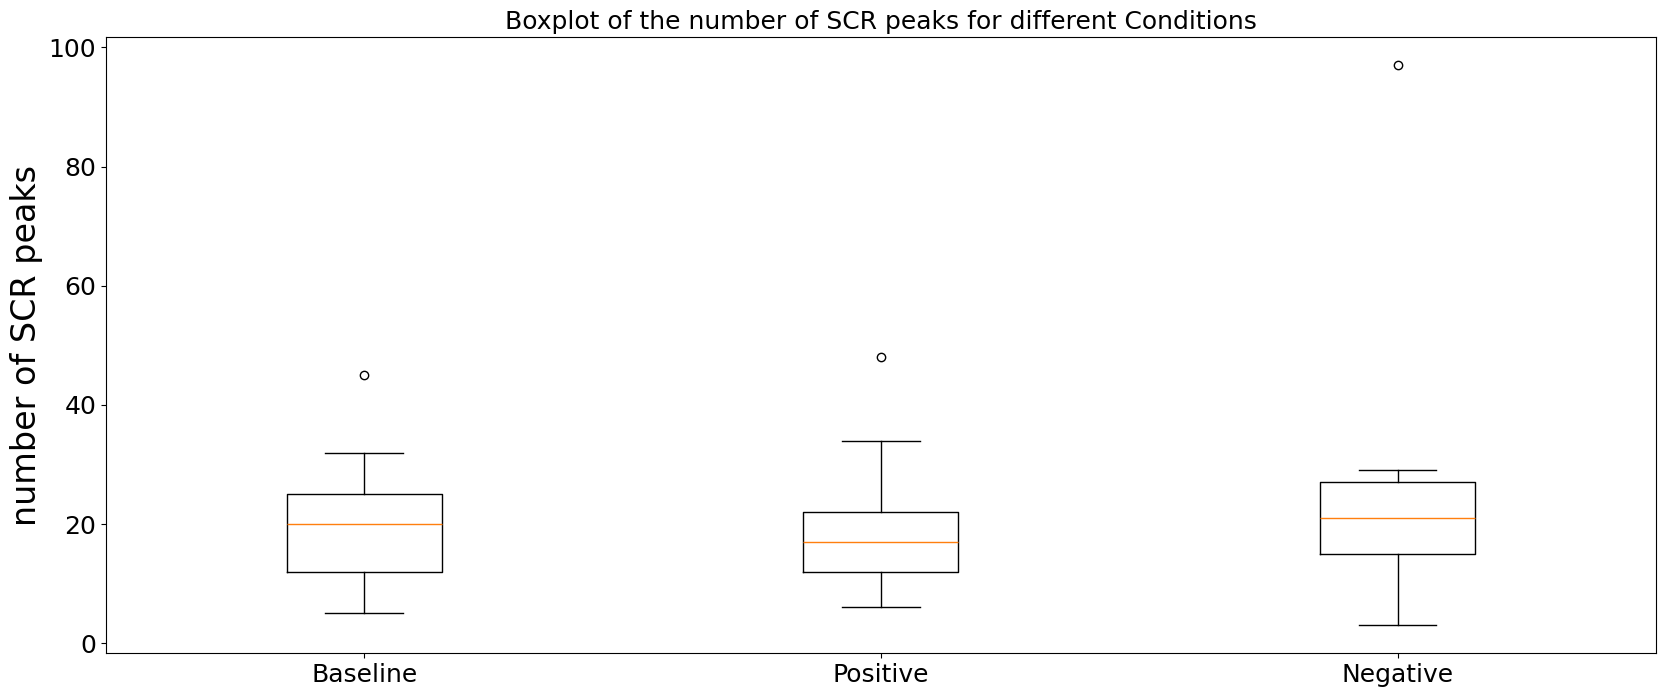

In [40]:
# 2. Choose and run the test
if all(ps):  # All normal
    print('Doing anova')
    # Repeated Measures ANOVA
    anova = pg.rm_anova(data=df_long, dv='Slope', within='Condition', subject='Participant')
    print("\nRepeated Measures ANOVA Results:")
    print(anova)
    if anova['p-unc'][0] < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc tests...")
        # Post-hoc paired t-tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                t_stat, p_val = stats.ttest_rel(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2  # Bonferroni
                print(f"Paired t-test {cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")
else:
    print('Doing Friedman')
    # Friedman Test (non-parametric)
    stat, p = stats.friedmanchisquare(df['Baseline'], df['Positive'], df['Negative'])
    print("\nFriedman Test Results:")
    print(f"Chi-square={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...")
        # Post-hoc Wilcoxon Signed-Rank tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
                print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

# Optional: Visualize the data
plt.boxplot([df['Baseline'], df['Positive'], df['Negative']], tick_labels=['Baseline', 'Positive', 'Negative'])
plt.title('Boxplot of the number of SCR peaks for different Conditions', fontsize=18)
plt.ylabel('number of SCR peaks', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [41]:
np.random.seed(42)  # For reproducibility
n_participants = len(ampl_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline': ampl_peaks_bas,  
    'Positive': ampl_peaks_pos,
    'Negative': ampl_peaks_neg
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline: statistic=0.830, p=0.005
  Baseline is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive: statistic=0.673, p=0.000
  Positive is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative: statistic=0.661, p=0.000
  Negative is not normally distributed (p < 0.05)


Doing Friedman

Friedman Test Results:
Chi-square=0.471, p=0.790


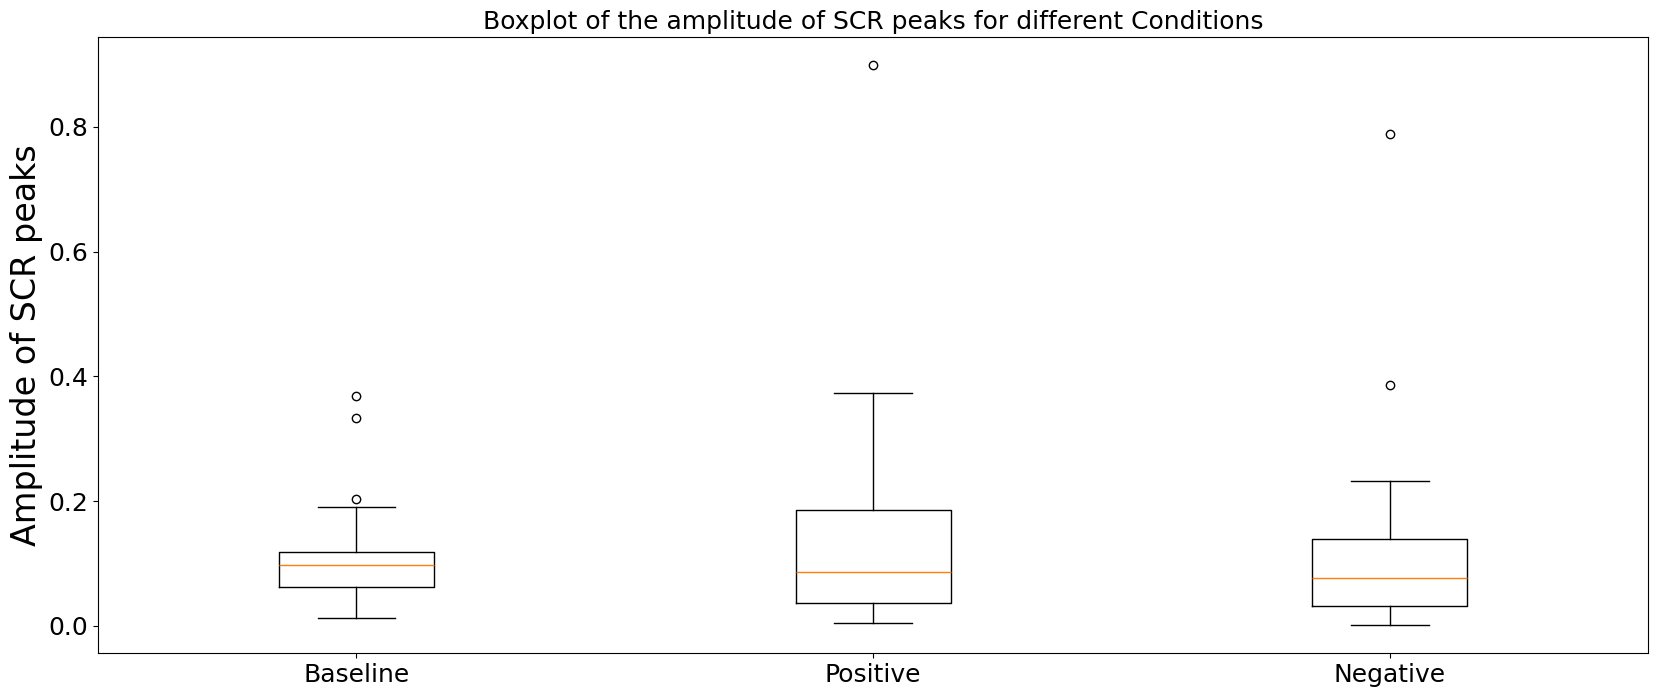

In [42]:
# 2. Choose and run the test
if all(ps):  # All normal
    print('Doing anova')
    # Repeated Measures ANOVA
    anova = pg.rm_anova(data=df_long, dv='Slope', within='Condition', subject='Participant')
    print("\nRepeated Measures ANOVA Results:")
    print(anova)
    if anova['p-unc'][0] < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc tests...")
        # Post-hoc paired t-tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                t_stat, p_val = stats.ttest_rel(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2  # Bonferroni
                print(f"Paired t-test {cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")
else:
    print('Doing Friedman')
    # Friedman Test (non-parametric)
    stat, p = stats.friedmanchisquare(df['Baseline'], df['Positive'], df['Negative'])
    print("\nFriedman Test Results:")
    print(f"Chi-square={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...")
        # Post-hoc Wilcoxon Signed-Rank tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
                print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

# Optional: Visualize the data
plt.boxplot([df['Baseline'], df['Positive'], df['Negative']], tick_labels=['Baseline', 'Positive', 'Negative'])
plt.title('Boxplot of the amplitude of SCR peaks for different Conditions', fontsize=18)
plt.ylabel('Amplitude of SCR peaks', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()